In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,confusion_matrix,roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
from pathlib import Path
from scipy import stats

def cal_metrics(y_train,y_proba,echo=False):
    y_train=np.array(y_train)
    y_proba=np.array(y_proba)
    y_pred = (y_proba > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_train, y_pred)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    auc = roc_auc_score(y_train, y_proba)
    ret =dict(
        sensitivity=sensitivity,
        specificity=specificity,
        auc=auc,
    )
    if echo:
        print("label\tsensitivity\tspecificity\tauc")
        print('1\t{:.2f}\t{:.2f}\t{:.2f}'.format(ret['sensitivity'], ret['specificity'], ret['auc']))
    return ret
def cal_multi_metric(y_train,y_proba,class_num=4,echo=False):
    if isinstance(y_proba,list):
        y_proba=np.array(y_proba)
    if isinstance(y_train,list):
        y_train=np.array(y_train)
    y_train = onehot(y_train)
    ret=dict()
    for i in range(class_num):
        ret[i]=cal_metrics(y_train[:,i],y_proba[:,i])
    if echo:
        print("label\tsensitivity\tspecificity\tauc")
        for k,v in ret.items():
            print('{}\t{:.2f}\t{:.2f}\t{:.2f}'.format(k, v['sensitivity'], v['specificity'], v['auc']))
    return ret
def calc_ci(data):
    confidence_interval = stats.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=stats.sem(data))
    print("{:.2f} (95% CI: {:.2f}-{:.2f})".format(np.mean(data), confidence_interval[0], confidence_interval[0]))
    
def onehot(y):
    return LabelBinarizer().fit_transform(y)

def impute(X):
    imputer = KNNImputer()
    imputer.fit(X)
    return imputer.transform(X)
def parse_result2(a, b):
    """
    index is target
    column is predicted result
    :param a: target 
    :param b: predict
    :return: 
    """
    out=[]
    for i in np.unique(a):
        out1=[]
        for j in np.unique(a):
            out1.append(np.sum((b[a==i]==j)))
        out.append(out1)
    
    df=pd.DataFrame(out,index=np.unique(a),columns=np.unique(a))
    return df
def plot_multi_roc(y_true,y_score,out=None,title=None, figure=True):
    if isinstance(y_score,list):
        y_score=np.array(y_score)
    y_true = onehot(y_true)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    color=['green','cyan','orange','red']
    stage=['CTL','AIS','MIA','IAC']
    if figure:
        plt.figure(figsize=(4,4))
    for i in range(4):
        plt.plot(fpr[i], tpr[i], color=color[i], label='{0} AUC: {1:0.2f}'.format(stage[i], roc_auc[i]),linewidth=0.5)
    plt.plot(fpr["micro"], tpr["micro"], label='average AUC: {0:0.2f}'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=1)
    plt.plot([0, 1], [0, 1], 'k--',linewidth=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity', fontsize=16)
    plt.ylabel('Sensitivity',fontsize=16)
    plt.legend(loc="lower right")
    if title:
        plt.title(title)
    if out:
        plt.savefig(out)
def plot_multi_roc_train_test(y_train_true, y_train_score, y_test_true,y_test_score,out=None,title1=None,title2=None):
    plt.figure(figsize=(8,3.8))
    plt.subplot(1, 2, 1)
    plot_multi_roc(y_train_true,y_train_score,figure=False,title=title1)
    plt.subplot(1, 2, 2)
    plot_multi_roc(y_test_true,y_test_score,figure=False,title=title2)
    plt.tight_layout()
    if out:
        plt.savefig(out)
def plot_roc(y_true,y_score,out=None,title=None, figure=True):
    if isinstance(y_true, np.ndarray):
        y_true=y_true.ravel()
    if isinstance(y_score, np.ndarray):
        y_score= y_score.ravel()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    if figure:
        plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr,label='AUC: {0:0.2f}'.format(roc_auc), color='red',linewidth=0.5)
    plt.plot([0, 1], [0, 1], 'k--',linewidth=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity', fontsize=16)
    plt.ylabel('Sensitivity',fontsize=16)
    plt.legend(loc="lower right")
    if title:
        plt.title(title)
    if out:
        plt.savefig(out)
def plot_roc_train_test(y_train_true, y_train_score, y_test_true,y_test_score,out=None,title1=None,title2=None):
    plt.figure(figsize=(8,3.8))
    plt.subplot(1, 2, 1)
    plot_roc(y_train_true,y_train_score,figure=False,title=title1)
    plt.subplot(1, 2, 2)
    plot_roc(y_test_true,y_test_score,figure=False,title=title2)
    plt.tight_layout()
    if out:
        plt.savefig(out)
##################################################################################################################
DataPath=Path('../data/intermediate/marker')
ReportPath=Path('../data/result')


data450k=dict(
    data=pd.read_csv(DataPath/'HM450k.txt',sep='\t',header=None).T.values,
    label=pd.read_csv(DataPath/'HM450k.group.2class.txt',sep='\t',header=None).values.flatten(),
    label2=pd.read_csv(DataPath/'HM450k.group.5class.txt',sep='\t',header=None).values.flatten(),
    feature=pd.read_csv(DataPath/'HM450k.feature.txt',sep='\t',header=None).values.flatten(),
)
dataWGBS=dict(
    data=pd.read_csv(DataPath/'wgbs.txt',sep='\t',header=None).T.values,
    label=pd.read_csv(DataPath/'wgbs.group.txt',sep='\t',header=None).values.flatten(),
    feature=pd.read_csv(DataPath/'wgbs.feature.txt',sep='\t',header=None).values.flatten(),
)
dataWGBSDMR=dict(
    data=pd.read_csv(DataPath/'wgbs.DMR.txt',sep='\t',header=None).T.values,
    label=pd.read_csv(DataPath/'wgbs.DMR.group.txt',sep='\t',header=None).values.flatten(),
    feature=pd.read_csv(DataPath/'wgbs.DMR.feature.txt',sep='\t',header=None).values.flatten(),
)
dataWGBS['data']=impute(dataWGBS['data'])
dataWGBSDMR['data']=impute(dataWGBSDMR['data'])


# Random Forest
## WGBS MultiClassifier
### 5-fold

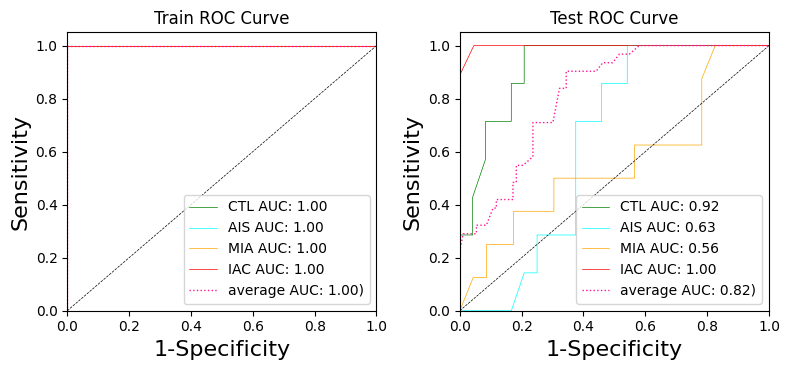

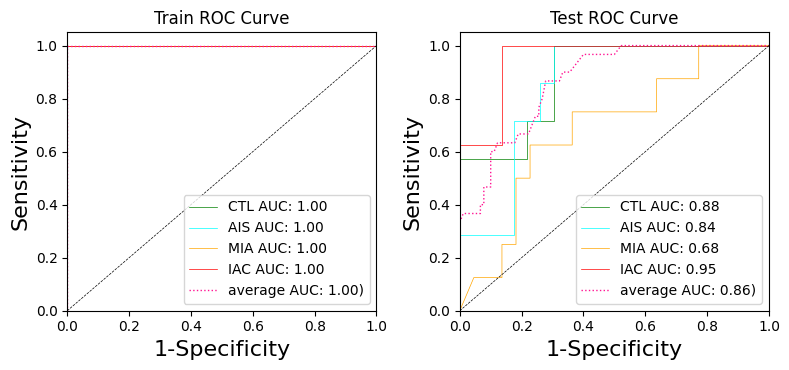

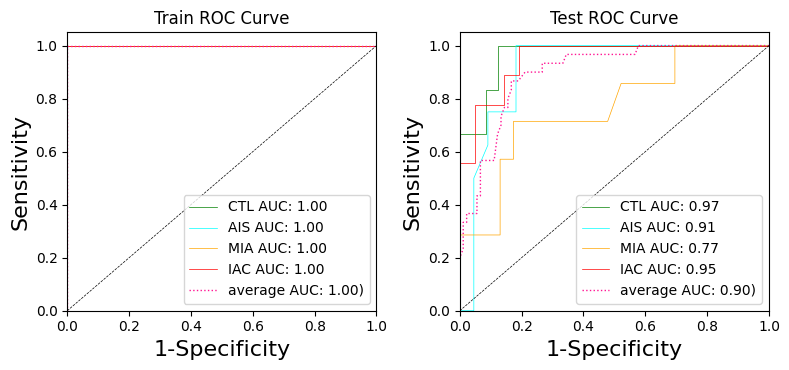

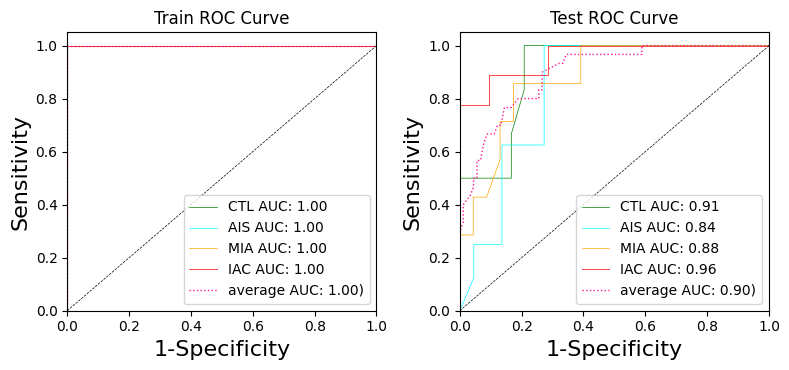

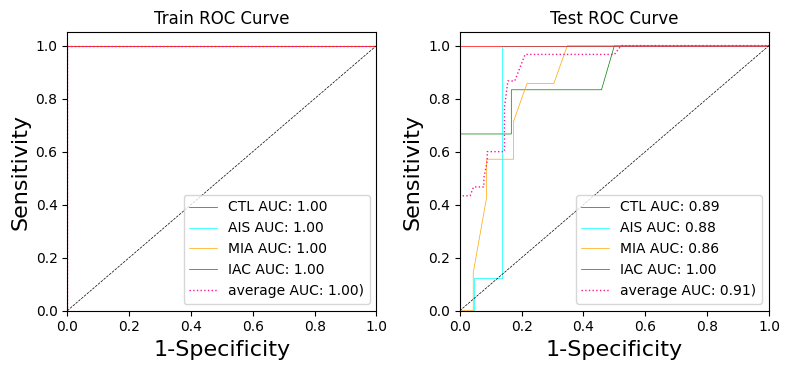

In [4]:
X=dataWGBS['data']
y=dataWGBS['label']
feature=dataWGBS['feature']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
def rfWGBSClassMulti(X_train,  y_train, X_test=None,y_test=None,feature=feature,quiet=False):
    classifier = RandomForestClassifier(random_state=100)
    classifier.fit(X_train,y_train)
    y_train_proba = classifier.predict_proba(X_train)
    if X_test is not None:
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if not quiet:
            # print("Accuracy:", accuracy)
            # print(parse_result2(y_test, y_pred))
            plot_multi_roc_train_test(y_train, y_train_proba,y_test, y_proba,title1="Train ROC Curve",title2="Test ROC Curve")
        return dict(
            y_train=y_train,
            y_train_proba=y_train_proba,
            y_test=y_test,
            y_test_proba=y_proba
        )
    else:
        plot_multi_roc(y_train, y_train_proba)
    return pd.DataFrame(dict(feature=feature,inportance=classifier.feature_importances_))
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    rfWGBSClassMulti(X[train_index,:],y[train_index], X[test_index,:], y[test_index],feature=feature)

### LeaveOneOut

100%|██████████| 151/151 [01:14<00:00,  2.03it/s]


label	sensitivity	specificity	auc
0	0.53	0.98	0.90
1	0.08	0.91	0.80
2	0.16	0.93	0.75
3	0.77	0.96	0.95


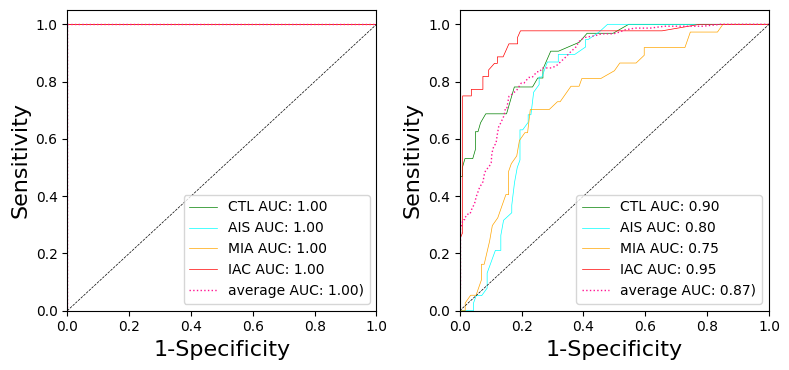

In [5]:
totalYTrain=[]
totalYTrainProba=[]
totalYTest=[]
totalYTestProba=[]
loo = LeaveOneOut()
for train_index, test_index in tqdm(loo.split(X),total=loo.get_n_splits(X)):
    p=rfWGBSClassMulti(X[train_index,:],y[train_index], X[test_index,:],  y[test_index], feature=feature,quiet=True)
    totalYTrain.extend(p['y_train'])
    totalYTrainProba.extend(p['y_train_proba'])
    totalYTest.extend(p['y_test'])
    totalYTestProba.extend(p['y_test_proba'])
cal_multi_metric(totalYTest,totalYTestProba, echo=True)
plot_multi_roc_train_test(totalYTrain,totalYTrainProba,totalYTest,totalYTestProba,out=ReportPath/'markder.wgbs.class4.leveOneOut.pdf')

### Total

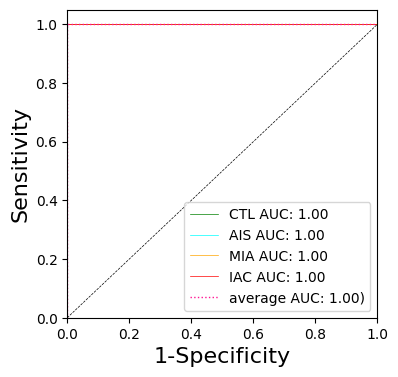

In [6]:
df=rfWGBSClassMulti(X, y,feature=feature)
df.to_csv(DataPath/"wgbs.featureImportance.class4.csv", index=False)

## WGBS 2 Classifier
### 5-fold

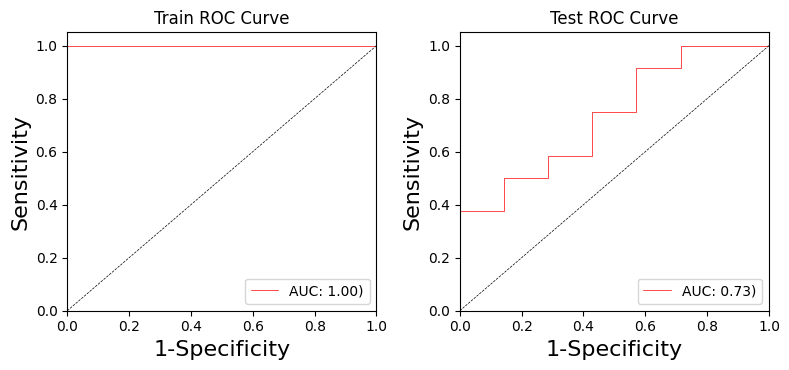

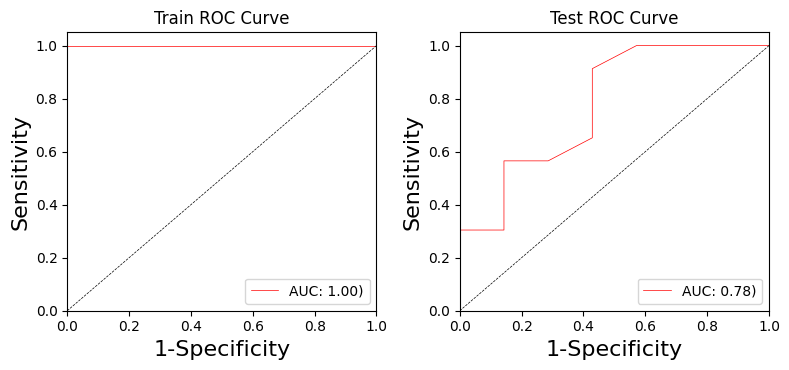

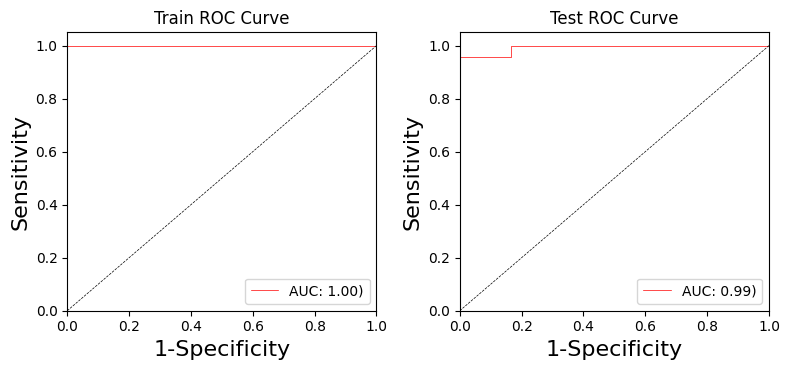

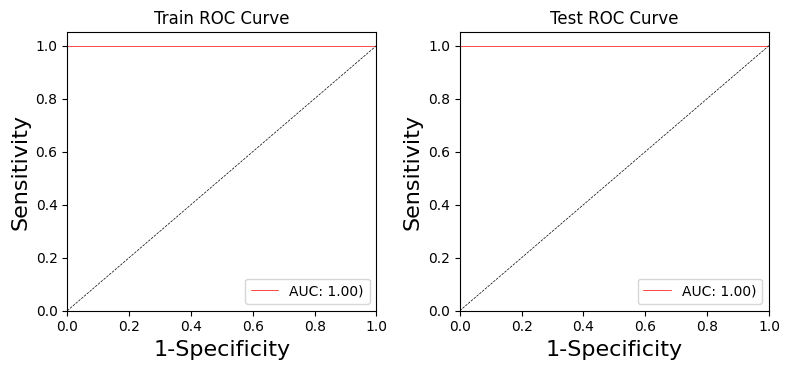

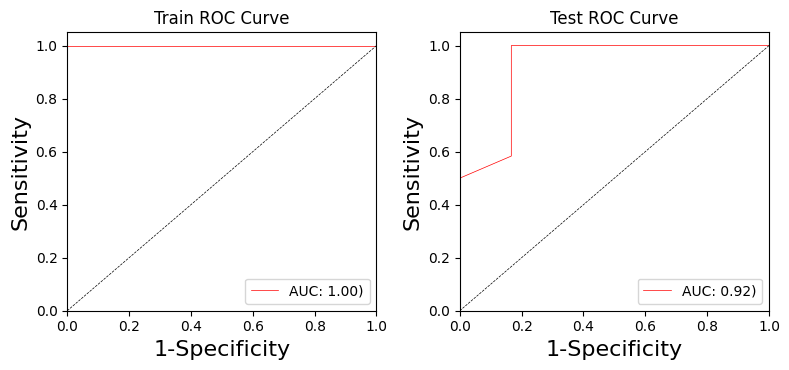

In [8]:
X=dataWGBS['data']
y=dataWGBS['label']
y[dataWGBS['label']!=0]=1
feature=dataWGBS['feature']
def rfWGBSClass2(X_train, y_train, X_test=None, y_test=None,feature=feature, quiet=False):
    classifier = RandomForestClassifier(random_state=100)
    classifier.fit(X_train,y_train)
    y_train_proba = classifier.predict_proba(X_train)[:,1]
    if X_test is not None:
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:,1]
        accuracy = accuracy_score(y_test, y_pred)
        if not quiet:
            # print("Accuracy:", accuracy)
            # print(parse_result2(y_test, y_pred))
            plot_roc_train_test(y_train, y_train_proba,y_test, y_proba,title1="Train ROC Curve",title2="Test ROC Curve")
        return dict(
            y_train=y_train,
            y_train_proba=y_train_proba,
            y_test=y_test,
            y_test_proba=y_proba
        )
    else:
        plot_roc(y_train, y_train_proba)
        return pd.DataFrame(dict(feature=feature,inportance=classifier.feature_importances_))
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    rfWGBSClass2(X[train_index,:],y[train_index], X[test_index,:],  y[test_index])    

### LeaveOneOut

100%|██████████| 151/151 [01:05<00:00,  2.32it/s]


label	sensitivity	specificity	auc
1	0.97	0.53	0.89


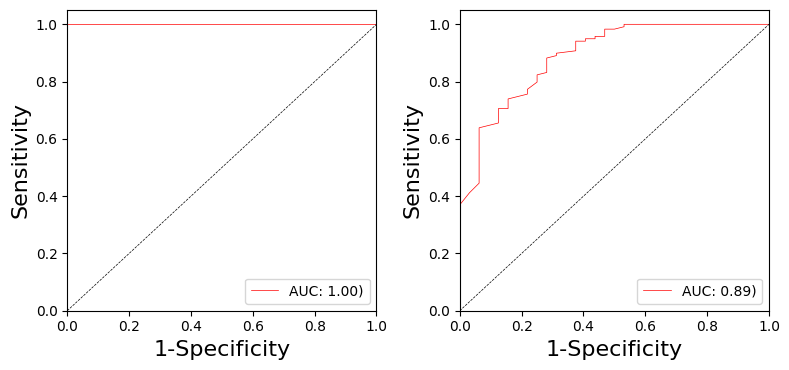

In [9]:
totalYTrain=[]
totalYTrainProba=[]
totalYTest=[]
totalYTestProba=[]
loo = LeaveOneOut()
for train_index, test_index in tqdm(loo.split(X),total=loo.get_n_splits(X)):
    p=rfWGBSClass2(X[train_index,:],y[train_index], X[test_index,:],  y[test_index], feature=feature,quiet=True)
    totalYTrain.extend(p['y_train'])
    totalYTrainProba.extend(p['y_train_proba'])
    totalYTest.extend(p['y_test'])
    totalYTestProba.extend(p['y_test_proba'])
cal_metrics(totalYTest,totalYTestProba, echo=True)
plot_roc_train_test(totalYTrain,totalYTrainProba,totalYTest,totalYTestProba,out=ReportPath/'markder.wgbs.class2.leveOneOut.pdf')

### Total

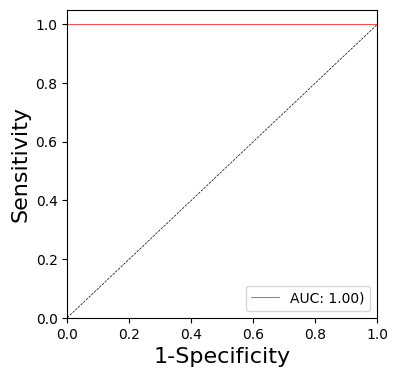

In [10]:
df=rfWGBSClass2(X, y,feature=feature)
df.to_csv(DataPath/"wgbs.featureImportance.class2.csv", index=False)

## HM450k 2 Classifier
### 5-fold

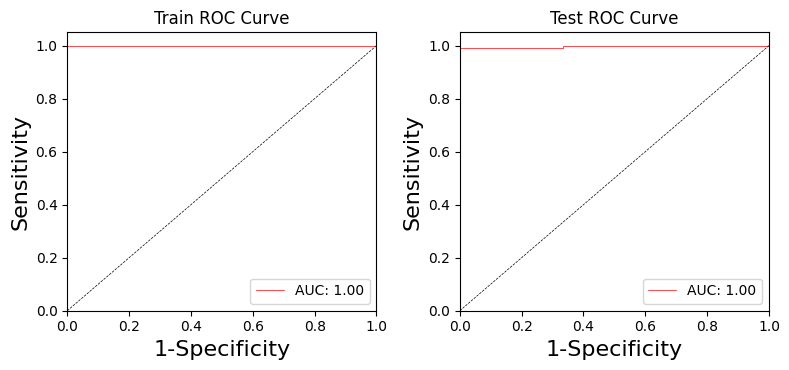

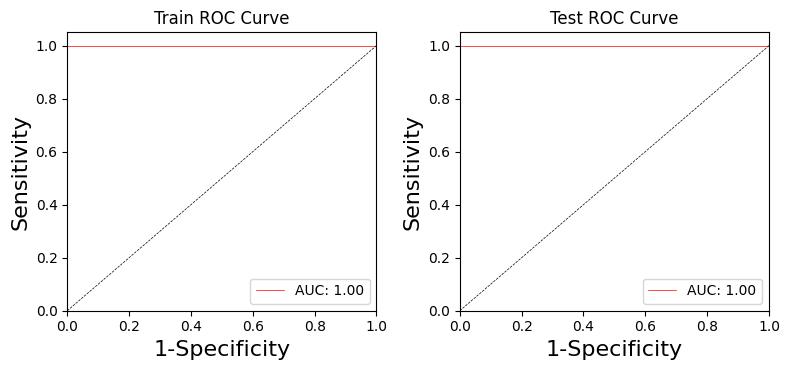

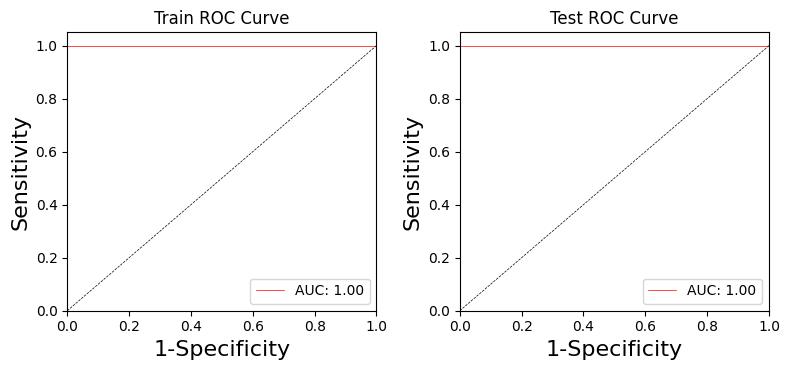

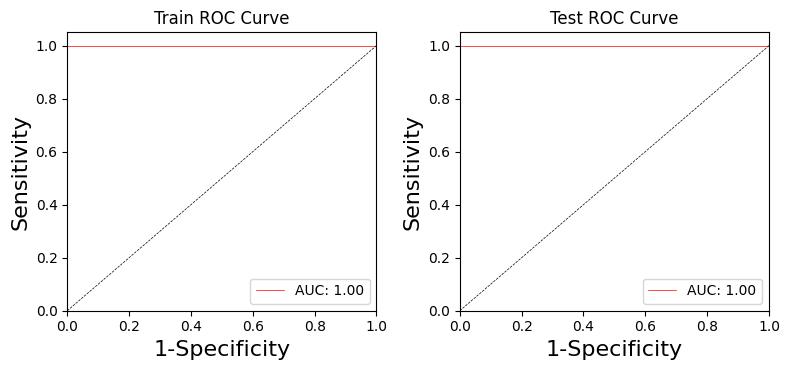

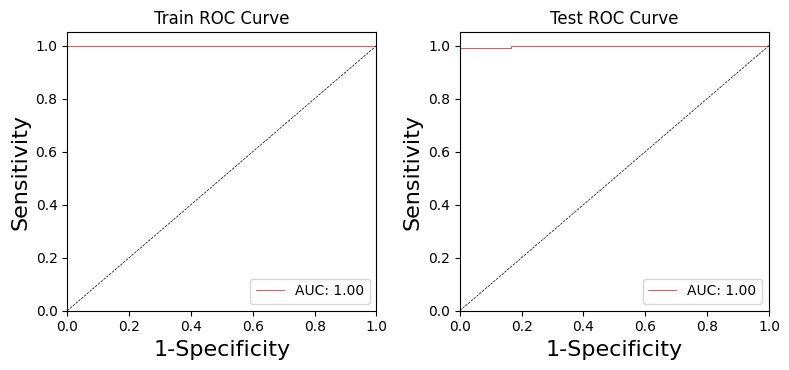

In [2]:
X=data450k['data']
y=data450k['label']
feature=data450k['feature']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
def hm450kWGBSClass2(X_train, y_train,X_test=None, y_test=None,feature=feature, quiet=False):
    classifier = RandomForestClassifier(random_state=100)
    classifier.fit(X_train,y_train)
    y_train_proba = classifier.predict_proba(X_train)[:,1]
    if X_test is not None:
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:,1]
        accuracy = accuracy_score(y_test, y_pred)
        if not quiet:
            # print("Accuracy:", accuracy)
            # print(parse_result2(y_test, y_pred))
            plot_roc_train_test(y_train, y_train_proba,y_test, y_proba,title1="Train ROC Curve",title2="Test ROC Curve")
        return dict(
            y_train=y_train,
            y_train_proba=y_train_proba,
            y_test=y_test,
            y_test_proba=y_proba
        )
    else:
        plot_roc(y_train, y_train_proba)
    return pd.DataFrame(dict(feature=feature,inportance=classifier.feature_importances_))
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    hm450kWGBSClass2(X[train_index,:],y[train_index],X[test_index,:],  y[test_index],feature=feature)

### LeaveOneOut

100%|██████████| 503/503 [05:59<00:00,  1.40it/s]


label	sensitivity	specificity	auc
1	1.00	0.88	1.00


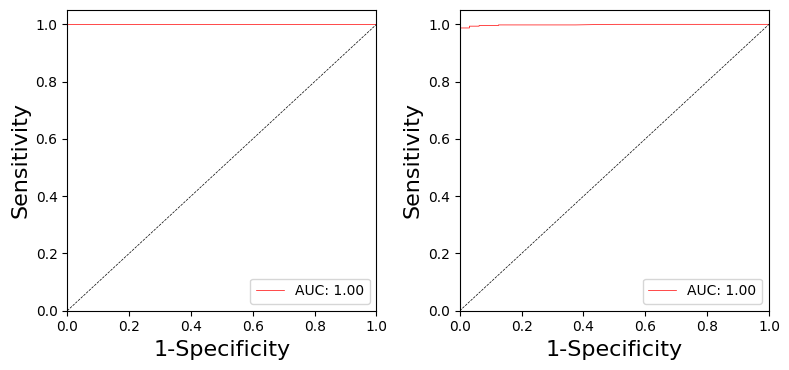

In [3]:
totalYTrain=[]
totalYTrainProba=[]
totalYTest=[]
totalYTestProba=[]
loo = LeaveOneOut()
for train_index, test_index in tqdm(loo.split(X),total=loo.get_n_splits(X)):
    p=hm450kWGBSClass2(X[train_index,:],y[train_index], X[test_index,:],  y[test_index], feature=feature,quiet=True)
    totalYTrain.extend(p['y_train'])
    totalYTrainProba.extend(p['y_train_proba'])
    totalYTest.extend(p['y_test'])
    totalYTestProba.extend(p['y_test_proba'])
cal_metrics(totalYTest,totalYTestProba, echo=True)
plot_roc_train_test(totalYTrain,totalYTrainProba,totalYTest,totalYTestProba,out=ReportPath/'markder.hm450k.class2.leveOneOut.pdf')

### Total

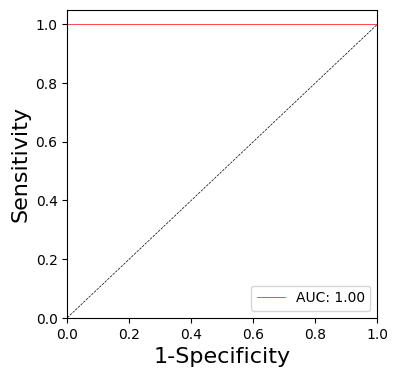

In [4]:
df=hm450kWGBSClass2(X, y,feature=feature)
df.to_csv(DataPath/"HM450k.featureImportance.class2.csv", index=False)